In [1]:
# Note that I am just displaying the augmented images and not saving them,
# but if you want to use these augmentation techniques for training a CNN, you can create CPU threads to 
# perform these augmentation operations in batches 

In [2]:
from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import transform, io

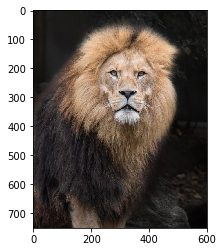

In [3]:
image = ndimage.imread("/Users/Madhav/Desktop/ML Projects/Lion.jpeg") # Paste address of image
plt.imshow(image, cmap = plt.get_cmap('gray')) # use matplotlib to show image
plt.show()

In [ ]:
# ------------ Mirroring -------------- #

In [4]:
# Function to flip the numpy array in the horizontal direction
def mirror_image(img):
    img = np.fliplr(img)
    
    return img

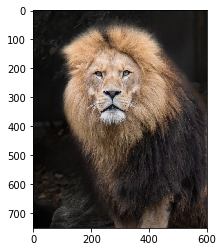

In [5]:
mirror = mirror_image(image)
plt.imshow(mirror, cmap = plt.get_cmap('gray')) # Display the mirrored image 
plt.show()

In [ ]:
# ------------ Random Cropping -------------- #

In [6]:
# A function which returns a set of valid x and y pixel positions of the top-left corner of a crop i.e.
# Given the crop size, any pair of values from the 2 lists can be used to generate a valid crop

def valid_points(img, output_shape):
    output_height = output_shape[0]
    output_width = output_shape[1]
    image_height, image_width, _ = img.shape
    valid_height = list(range(0, (image_height - output_height)))
    valid_width = list(range(0, (image_width - output_width)))
    
    return valid_height, valid_width, output_height, output_width

In [7]:
# Now that we have the list of valid x and y positions, we choose random pairs from these lists so as to create random crops

def random_crops(img, num_crops, output_shape):
    cropped_images = []
    x0_list, y0_list, output_height, output_width = valid_points(img, output_shape)
    rand_x0 = random.sample(x0_list, num_crops) # Get n different x0 values
    rand_y0 = random.sample(y0_list, num_crops) # Get n different y0 values
    for i in range(num_crops):  # Now take paird of the random values to create crops 
        x0 = rand_x0[i]
        y0 = rand_y0[i]
        crop = img[x0:x0+output_height, y0:y0+output_width]
        cropped_images.append(crop)
    
    return cropped_images

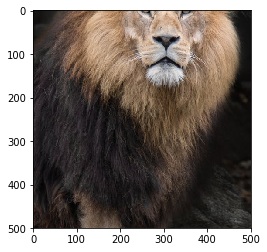

In [10]:
crops = random_crops(image, 2, (500,500))
plt.imshow(crops[1], cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
# ------------ Fancy PCA / Color Augmentation -------------- #

In [11]:
# Read the list of images given and create a (N, height, width, channel) shaped matrix , where
# N = number of examples / batch_size and height, width, channels being the dimensions for which you want to train your CNN
# Note that as the input images might be of varied sizes, the resize operation is used 
# I have used (256, 256) as default, but this can be accepted as an argument

def read_image(image_location):
    image_list = io.imread_collection(image_location)
    resized_image_list = io.concatenate_images([transform.resize(x, (256,256), preserve_range = True) for x in image_list]) / 255
    
    return resized_image_list

In [12]:
# Flatten the array into pixels of RGB values i.e of shape (None, 3)

def convert_to_rgb_array(image_list):
    rgb_array = image_list.reshape(image_list.shape[0] * image_list.shape[1] * image_list.shape[2], image_list.shape[3])
    
    return rgb_array

In [13]:
# Compute the eigen values and eigenvectors by using SVD 
# Note that the eigen values is the square root of S as our covariance matrix will always be symmetric

def compute_eigen(rgb_array):
    cov = np.cov(rgb_array.T)
    U,S,V = np.linalg.svd(cov)
    EigenValues = np.sqrt(S)
    
    return U, EigenValues

In [14]:
# Generate color_jitters as is mentioned in Alex Krizhevsky et. al.

def generate_noise(U, EigenValues, mu = 0, sigma = 0.1):
    samples = np.random.normal(mu, sigma, 3)
    noise = (np.dot(U, (samples * EigenValues).T)) #np.sum((U * (samples * S)), axis = 1)
    
    return noise

In [15]:
# Add the noise to the RGB values to get the augmented images

def get_color_aug_image(orig_image_list, noise):
    aug_image_list = np.copy(orig_image_list)
    for idx in range(orig_image_list.shape[0]):
        aug_img = orig_image_list[idx] + noise[np.newaxis, np.newaxis, :]
        aug_img[aug_img > 1.0] = 1.0
        aug_img[aug_img < 0.0] = 0.0
        aug_image_list[idx] = aug_img
    
    return aug_image_list
        

In [16]:
image_location = ['/Users/Madhav/Desktop/ML Projects/Lion.jpeg', '/Users/Madhav/Desktop/ML Projects/Test.png', '/Users/Madhav/Desktop/ML Projects/fruitbasket.jpg', '/Users/Madhav/Desktop/ML Projects/iniesta.jpg', '/Users/Madhav/Desktop/ML Projects/eagle.jpg', '/Users/Madhav/Desktop/ML Projects/ganesha.jpg']
image_list = read_image(image_location)
rgb_array = convert_to_rgb_array(image_list)
U, EigenValues = compute_eigen(rgb_array)
noise = generate_noise(U, EigenValues)
aug_image_list = get_color_aug_image(image_list, noise)

/Users/Madhav/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


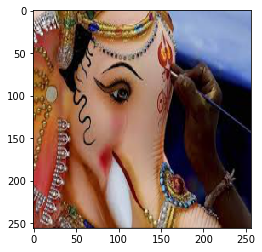

In [17]:
plt.imshow(image_list[5], cmap = plt.get_cmap('gray'))
plt.show()

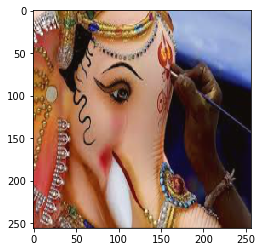

In [18]:
plt.imshow(aug_image_list[5], cmap = plt.get_cmap('gray'))
plt.show()

In [19]:
image_list[5]

array([[[ 0.8056193 ,  0.70810858,  0.65455912],
        [ 0.85742188,  0.75991115,  0.71283701],
        [ 0.83932907,  0.74181834,  0.6947442 ],
        ..., 
        [ 0.48755362,  0.56762825,  0.72181446],
        [ 0.48755362,  0.56825214,  0.71619945],
        [ 0.48755362,  0.56825214,  0.71619945]],

       [[ 0.97315835,  0.87023736,  0.81210511],
        [ 0.97257017,  0.85884468,  0.80394272],
        [ 0.95414249,  0.8408334 ,  0.78593144],
        ..., 
        [ 0.56638327,  0.65977328,  0.84325421],
        [ 0.56638327,  0.66050092,  0.8375383 ],
        [ 0.56638327,  0.66050092,  0.8375383 ]],

       [[ 0.99112212,  0.89085616,  0.83595419],
        [ 0.93668339,  0.8229579 ,  0.76805593],
        [ 0.93518578,  0.82218792,  0.76770379],
        ..., 
        [ 0.56245404,  0.65584406,  0.84205729],
        [ 0.56245404,  0.65657169,  0.83696385],
        [ 0.56245404,  0.65657169,  0.83696385]],

       ..., 
       [[ 0.59196258,  0.19204615,  0.1426937 ],
        

In [20]:
aug_image_list[5]

array([[[ 0.86011344,  0.74638852,  0.68026272],
        [ 0.91191602,  0.79819109,  0.73854061],
        [ 0.89382321,  0.78009828,  0.7204478 ],
        ..., 
        [ 0.54204776,  0.60590819,  0.74751806],
        [ 0.54204776,  0.60653208,  0.74190305],
        [ 0.54204776,  0.60653208,  0.74190305]],

       [[ 1.        ,  0.90851729,  0.83780871],
        [ 1.        ,  0.89712462,  0.82964632],
        [ 1.        ,  0.87911334,  0.81163504],
        ..., 
        [ 0.62087741,  0.69805322,  0.86895781],
        [ 0.62087741,  0.69878085,  0.8632419 ],
        [ 0.62087741,  0.69878085,  0.8632419 ]],

       [[ 1.        ,  0.92913609,  0.8616578 ],
        [ 0.99117753,  0.86123783,  0.79375954],
        [ 0.98967992,  0.86046786,  0.79340739],
        ..., 
        [ 0.61694819,  0.69412399,  0.86776089],
        [ 0.61694819,  0.69485163,  0.86266745],
        [ 0.61694819,  0.69485163,  0.86266745]],

       ..., 
       [[ 0.64645672,  0.23032608,  0.16839731],
        